In [1]:
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K 
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path='chest_xray/train'
val_path='chest_xray/val'
test_path='chest_xray/test'

In [3]:
train_batches=ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224), classes=['Normal','Pneumonia'],batch_size=16)
valid_batches=ImageDataGenerator().flow_from_directory(val_path,target_size=(224,224), classes=['Normal','Pneumonia'],batch_size=4)
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224), classes=['Normal','Pneumonia'],batch_size=16)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.models import Model

In [5]:
resnet = ResNet50V2(input_shape=[224, 224, 3], weights='imagenet', include_top=False)

94674944/94668760 [==============================] - 174s 2us/step


In [6]:
for layer in resnet.layers:
    layer.trainable=False

In [7]:
x = Flatten()(resnet.output)
prediction = Dense(2, activation='softmax')(x)

In [8]:
model = Model(inputs=resnet.input, outputs=prediction)

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [10]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
train = model.fit_generator(train_batches, epochs=5, steps_per_epoch=326, validation_data=valid_batches, validation_steps=16)

Epoch 1/5
326/326 [==============================] - 139s 427ms/step - loss: 0.1692 - accuracy: 0.9459 - val_loss: 426.0134 - val_accuracy: 0.5000
Epoch 2/5
326/326 [==============================] - 103s 316ms/step - loss: 0.0401 - accuracy: 0.9860 - val_loss: 1142.0304 - val_accuracy: 0.5000
Epoch 3/5
326/326 [==============================] - 114s 351ms/step - loss: 0.0136 - accuracy: 0.9956 - val_loss: 437.1246 - val_accuracy: 0.5000
Epoch 4/5
326/326 [==============================] - 124s 380ms/step - loss: 0.0069 - accuracy: 0.9983 - val_loss: 231.1213 - val_accuracy: 0.5000
Epoch 5/5
326/326 [==============================] - 131s 402ms/step - loss: 0.0108 - accuracy: 0.9958 - val_loss: 0.0000e+00 - val_accuracy: 0.5000


In [12]:
model.save('ResNet-50V2.h5')

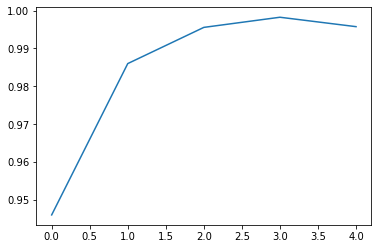

In [13]:
plt.plot(train.history['accuracy'])

In [14]:
def plot_confusion_matrix(cm,classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion amtrix, without normalization')
        
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [15]:
predictions = model.predict_generator(test_batches)

Confusion amtrix, without normalization
[[234   0]
 [390   0]]


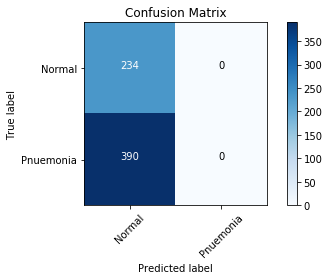

In [16]:
cm = confusion_matrix(test_batches.labels, np.round(predictions[:,0]))
cm_plot_labels=['Normal','Pnuemonia']
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')